# Predicción de sueldos

El objetivo de este notebook es hacer un modelo sencillo que pueda estimar el sueldo de una persona respondiendo una encuesta como la de sysarmy, usando los datos de principios de 2020.

## Baseline

Vamos a tomar un modelo de base para ver cuánto podemos mejorarlo. En análisis previos vimos que las tres características que más definen el sueldo son el género, la ubicación y cuánta gente a cargo tiene la persona. Vamos a hacer un modelo que dada estas tres características memorice el promedio de los valores vistos y estime eso. En caso de ser una combinación no vista puede devolver el promedio general.

In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import xgboost as xgb
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import Sequential
from keras.regularizers import l1, l2
from numpy.random import default_rng
import matplotlib.lines as mlines

%matplotlib inline

In [2]:
df = pd.read_csv('2020.2 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv')
df = df[df['Estoy trabajando en'] == 'Argentina']
df.head()

,Timestamp,Me identifico,Tengo,Estoy trabajando en,Dónde estás trabajando,Bolivia,Chile,Colombia,Cuba,Costa Rica,...,¿Con cuántas personas estás conviviendo?,¿Con quiénes convivís?,¿Tenés un espacio dedicado para el trabajo?,¿Tenés que compartir tu equipo de trabajo con alguien?,¿Qué tipo de cuarentena estás haciendo?,¿Cambió tu situación laboral a raíz de la pandemia?,¿Qué tanto sentís que te está apoyando tu empresa en esta situación?,¿Cómo se vio afectada tu empresa?,¿Instauraron algún beneficio nuevo?,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,7/6/2020 9:56:02,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,0,Vivo solo/a,No,No,4,Decidí buscar otro trabajo,7,No la afectó,No,NaN
1,7/6/2020 9:57:09,Hombre,29,Argentina,Corrientes,NaN,NaN,NaN,NaN,NaN,...,1,-,No,No,3,"Cambié de trabajo, pero no por la pandemia",8,No la afectó,No,NaN
2,7/6/2020 9:58:09,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,1,Pareja,No,No,4,"Cambié de trabajo, pero no por la pandemia",8,Se vio beneficiada,"Clases de gimnasia, Clases de meditación, Clas...",NaN
3,7/6/2020 9:59:52,Hombre,39,Argentina,Corrientes,NaN,NaN,NaN,NaN,NaN,...,1,Pareja,Sí,No,4,No,4,"Cerró oficinas, Bajaron los sueldos o pagan pa...",No,NaN
4,7/6/2020 10:01:27,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,NaN,NaN,NaN,NaN,NaN,...,2,"Pareja, Hijos/as (tiempo completo)",Sí,No,3,No,6,Nos obligaron a tomarnos vacaciones,No,NaN


In [3]:
df.shape

(6095, 81)

''

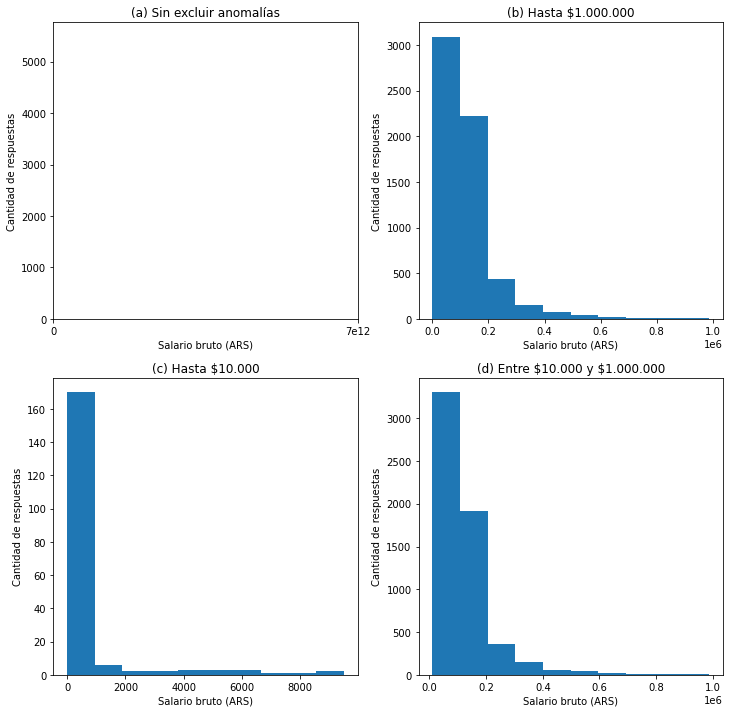

In [4]:
df_orig = pd.read_csv('2020.2 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv')
df_orig = df_orig[df_orig['Estoy trabajando en'] == 'Argentina']

f, _= plt.subplots(2, 2, figsize=(12, 12))
ax = plt.subplot(2, 2, 1)
ax.hist(df_orig['Salario mensual BRUTO (en tu moneda local)'])
ax.set_title('(a) Sin excluir anomalías')
ax.set_xlabel('Salario bruto (ARS)')
ax.set_ylabel('Cantidad de respuestas')
ax.set_xticks([0, 7_000_000_000_000])
ax.set_xticklabels(["0", "7e12"])

ax = plt.subplot(2, 2, 2)
ax.hist(df_orig[df_orig['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]['Salario mensual BRUTO (en tu moneda local)'])
ax.set_title('(b) Hasta $1.000.000')
ax.set_xlabel('Salario bruto (ARS)')
ax.set_ylabel('Cantidad de respuestas')

ax = plt.subplot(2, 2, 3)
ax.hist(df_orig[df_orig['Salario mensual BRUTO (en tu moneda local)'] < 10_000]['Salario mensual BRUTO (en tu moneda local)'])
ax.set_title('(c) Hasta $10.000')
ax.set_xlabel('Salario bruto (ARS)')
ax.set_ylabel('Cantidad de respuestas')

ax = plt.subplot(2, 2, 4)
ax.hist(df_orig[(df_orig['Salario mensual BRUTO (en tu moneda local)'] > 10_000) & (df_orig['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000)]['Salario mensual BRUTO (en tu moneda local)'])
ax.set_title('(d) Entre \\$10.000 y \\$1.000.000')
ax.set_xlabel('Salario bruto (ARS)')
ax.set_ylabel('Cantidad de respuestas')
;

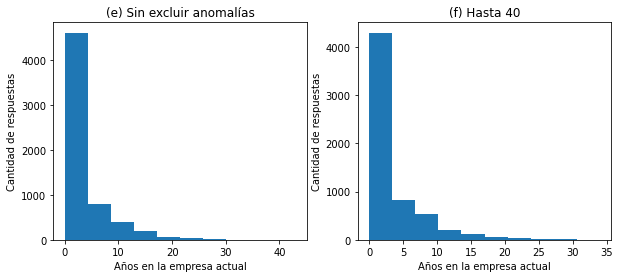

In [5]:
f, _= plt.subplots(1, 2, figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.hist(df_orig['Años en la empresa actual'])
ax.set_title('(e) Sin excluir anomalías')
ax.set_xlabel('Años en la empresa actual')
ax.set_ylabel('Cantidad de respuestas')

ax = plt.subplot(1, 2, 2)
ax.hist(df_orig[df_orig['Años en la empresa actual'] < 40]['Años en la empresa actual'])
ax.set_title('(f) Hasta 40')
ax.set_xlabel('Años en la empresa actual')
ax.set_ylabel('Cantidad de respuestas')

None

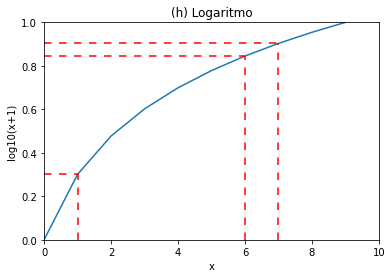

In [6]:
plt.title('(h) Logaritmo')

plt.ylabel('log10(x+1)')
plt.xlabel('x')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.plot(pd.Series(range(0, 10, 1)), np.log10(pd.Series(range(1, 11, 1))))
plt.axvline(1, 0, np.log10(2), dashes=(5, 5), color='red')
plt.axhline(np.log10(2), 0, 0.1, dashes=(5, 5), color='red')

plt.axvline(6, 0, np.log10(7), dashes=(5, 5), color='red')
plt.axhline(np.log10(7), 0, 0.6, dashes=(5, 5), color='red')
plt.axvline(7, 0, np.log10(8), dashes=(5, 5), color='red')
plt.axhline(np.log10(8), 0, 0.7, dashes=(5, 5), color='red')

None;

''

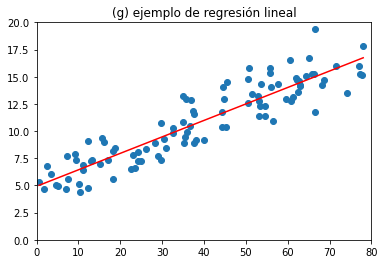

In [7]:
_, ax = plt.subplots(1, 1)
rng = default_rng(42)
xvals = rng.uniform(0, 80, 100)
f_x = 3*xvals/20+5
data = f_x + rng.normal(0, 1.5, 100)
ax.scatter(xvals, data)
model = LinearRegression().fit(xvals.reshape((-1, 1)), data)
ax.add_line(mlines.Line2D([xvals.min(),xvals.max()], [xvals.min() * model.coef_ + model.intercept_, xvals.max() * model.coef_ + model.intercept_], color='red'))
ax.set_xlim(0, 80)
ax.set_ylim(0, 20)
ax.set_title('(g) ejemplo de regresión lineal')
;

In [8]:
df.T.index

Index(['Timestamp', 'Me identifico', 'Tengo', 'Estoy trabajando en',
       'Dónde estás trabajando', 'Bolivia', 'Chile', 'Colombia', 'Cuba',
       'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras',
       'México', 'Nicaragua', 'Panamá', 'Paraguay', 'Perú', 'Puerto Rico',
       'República Dominicana', 'Uruguay', 'Venezuela', 'Años de experiencia',
       'Años en la empresa actual', 'Años en el puesto actual',
       '¿Gente a cargo?', 'Nivel de estudios alcanzado', 'Estado', 'Carrera',
       'Universidad', 'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salar

In [9]:
df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']]

,Me identifico,Dónde estás trabajando,¿Gente a cargo?
0,Mujer,Ciudad Autónoma de Buenos Aires,0
1,Hombre,Corrientes,4
2,Mujer,Ciudad Autónoma de Buenos Aires,0
3,Hombre,Corrientes,5
4,Hombre,Ciudad Autónoma de Buenos Aires,0
...,...,...,...
6410,Hombre,Ciudad Autónoma de Buenos Aires,0
6411,Hombre,Ciudad Autónoma de Buenos Aires,0
6412,Hombre,Ciudad Autónoma de Buenos Aires,0
6413,Hombre,La Pampa,0


In [10]:
df.groupby('Me identifico').size()

Me identifico
Hombre    5122
Mujer      942
Otros       31
dtype: int64

In [11]:
df.groupby('Dónde estás trabajando').size()

Dónde estás trabajando
Catamarca                             3
Chaco                                24
Chubut                               23
Ciudad Autónoma de Buenos Aires    3764
Corrientes                           19
Córdoba                             456
Entre Ríos                           66
Formosa                               4
GBA                                 524
Jujuy                                36
La Pampa                              9
La Rioja                             14
Mendoza                             107
Misiones                             26
Neuquén                              36
Provincia de Buenos Aires           497
Río Negro                            38
Salta                                14
San Juan                              7
San Luis                             14
Santa Cruz                            6
Santa Fe                            354
Santiago del Estero                  10
Tierra del Fuego                     11
Tucumán          

In [12]:
df.groupby('¿Gente a cargo?').size()

¿Gente a cargo?
0       4592
1        250
2        277
3        178
4        175
5        161
6         65
7         41
8         59
9         28
10        51
11         5
12        29
13         6
14         8
15        37
16         7
17         7
18         6
19         1
20        26
21         2
22         3
23         2
24         1
25        13
27         3
28         1
30        16
31         1
35         3
36         1
38         1
40         7
45         2
50         9
55         1
59         1
60         4
70         1
76         1
80         1
90         1
100        3
110        1
120        2
138        1
150        1
170        1
300        1
2500       1
dtype: int64

El género y provincia son variables categóricas, es decir que pueden obtener un conjunto de valores, mientras que gente a cargo es un número. Vemos también que algunas categorías tienen pocos datos, como género no binario o la provincia de Catamarca. En general esto va a ser un problema porque no va a generalizar muy bien ningún modelo con tan poca información.

Veamos si podemos agrupar estos.

In [13]:
df[['Me identifico', 'Salario mensual BRUTO (en tu moneda local)']].groupby('Me identifico').median()

,Salario mensual BRUTO (en tu moneda local)
Me identifico,
Hombre,100000.0
Mujer,80000.0
Otros,93000.0


In [6]:
df_provinces = df[['Dónde estás trabajando', 'Salario mensual BRUTO (en tu moneda local)']].groupby('Dónde estás trabajando').agg(['median', 'count']).sort_values(('Salario mensual BRUTO (en tu moneda local)', 'median'))
df_provinces

Salario mensual BRUTO (en tu moneda local)  \
                                                                    median   
Dónde estás trabajando                                                       
Santa Cruz                                                        37857.49   
Santiago del Estero                                               41000.00   
San Juan                                                          43000.00   
Catamarca                                                         52000.00   
Chaco                                                             53400.00   
Jujuy                                                             53500.00   
Misiones                                                          60240.48   
La Rioja                                                          61720.16   
Tucumán                                                           65000.00   
Salta                                                             66000.00   
Entre Ríos                                                        70100.00   
Formosa                                                           71049.00   
Corrientes                                                        72900.00   
Tierra del Fuego                                                  80000.00   
Mendoza                                                           85000.00   
La Pampa                                                          86000.00   
GBA                                                               86679.50   
Río Negro                                                         87500.00   
Provincia de Buenos Aires                                         87600.00   
Santa Fe                                                          88900.00   
Córdoba                                                           90000.00   
Neuquén                                                           91750.00   
Chubut                                                            95000.00   
Ciudad Autónoma de Buenos Aires                                  104000.00   
San Luis                                                         150497.50   

                                       
                                count  
Dónde estás trabajando                 
Santa Cruz                          6  
Santiago del Estero                10  
San Juan                            7  
Catamarca                           3  
Chaco                              24  
Jujuy                              36  
Misiones                           26  
La Rioja                           14  
Tucumán                            33  
Salta                              14  
Entre Ríos                         66  
Formosa                             4  
Corrientes                         19  
Tierra del Fuego                   11  
Mendoza                           107  
La Pampa                            9  
GBA                               524  
Río Negro                          38  
Provincia de Buenos Aires         497  
Santa Fe                          354  
Córdoba                           456  
Neuquén                            36  
Chubut                             23  
Ciudad Autónoma de Buenos Aires  3764  
San Luis                           14

In [3]:
provinces_geo = gpd.read_file('provincias_argentinas_polygon.geojson')
provinces_geo.head()

,cartodb_id,description,name,provincia,id,codpcia,c_indec,id_dyp,geometry
0,1,,,Ciudad Autónoma de Buenos Aires,1,1,2,1,"MULTIPOLYGON (((-58.39007 -34.66230, -58.39037..."
1,3,,,Catamarca,3,3,10,4,"MULTIPOLYGON (((-66.59111 -26.17318, -66.58961..."
2,4,,,Chaco,4,4,22,6,"MULTIPOLYGON (((-62.34757 -24.11021, -62.34407..."
3,5,,,Chubut,5,5,26,7,"MULTIPOLYGON (((-71.77158 -41.99955, -71.67446..."
4,7,,,Corrientes,7,7,18,5,"MULTIPOLYGON (((-58.89298 -27.99935, -58.89182..."


In [16]:
provinces_geo.provincia

0                Ciudad Autónoma de Buenos Aires
1                                      Catamarca
2                                          Chaco
3                                         Chubut
4                                     Corrientes
5                                     Entre Ríos
6                                        Formosa
7                                          Jujuy
8                                       La Pampa
9                                       La Rioja
10                                       Mendoza
11                                      Misiones
12                                       Neuquén
13                                     Río Negro
14                                         Salta
15                                      San Juan
16                                      San Luis
17                                    Santa Cruz
18                                      Santa Fe
19                           Santiago del Estero
20                  

In [4]:
provinces_geo['provincia'] = provinces_geo['provincia'].apply(lambda x: "Tierra del Fuego" if x == "Tierra del Fuego e Islas del Atlántico Sur" else x)

In [7]:
provinces = provinces_geo.join(df_provinces['Salario mensual BRUTO (en tu moneda local)'], on=['provincia'])
provinces

,cartodb_id,description,name,provincia,id,codpcia,c_indec,id_dyp,geometry,median,count
0,1,,,Ciudad Autónoma de Buenos Aires,1,1,2,1,"MULTIPOLYGON (((-58.39007 -34.66230, -58.39037...",104000.00,3764
1,3,,,Catamarca,3,3,10,4,"MULTIPOLYGON (((-66.59111 -26.17318, -66.58961...",52000.00,3
2,4,,,Chaco,4,4,22,6,"MULTIPOLYGON (((-62.34757 -24.11021, -62.34407...",53400.00,24
3,5,,,Chubut,5,5,26,7,"MULTIPOLYGON (((-71.77158 -41.99955, -71.67446...",95000.00,23
4,7,,,Corrientes,7,7,18,5,"MULTIPOLYGON (((-58.89298 -27.99935, -58.89182...",72900.00,19
5,8,,,Entre Ríos,8,8,30,8,"MULTIPOLYGON (((-59.66084 -30.34857, -59.65614...",70100.00,66
6,9,,,Formosa,9,9,34,9,"MULTIPOLYGON (((-62.34465 -22.45495, -62.33563...",71049.00,4
7,10,,,Jujuy,10,10,38,10,"MULTIPOLYGON (((-64.44379 -23.63491, -64.44048...",53500.00,36
8,11,,,La Pampa,11,11,42,11,"MULTIPOLYGON (((-65.10672 -34.99768, -65.02612...",86000.00,9
9,12,,,La Rioja,12,12,46,12,"MULTIPOLYGON (((-69.09436 -27.77274, -69.01274...",61720.16,14


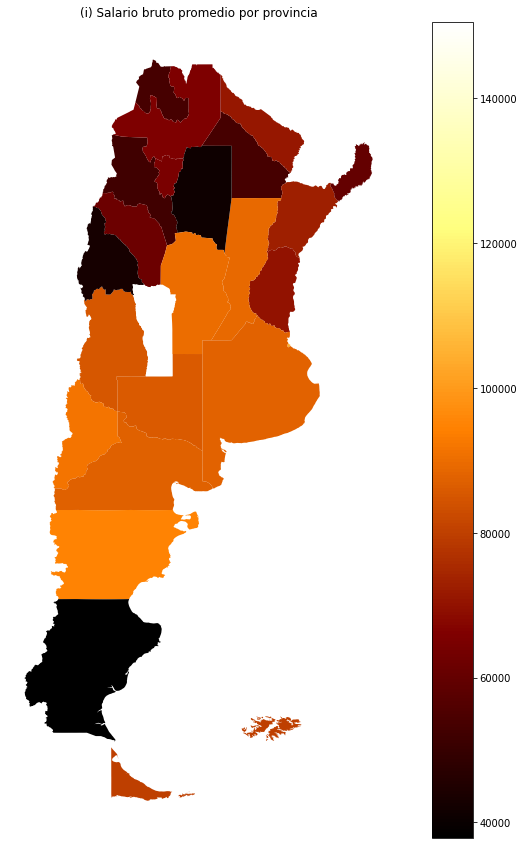

In [19]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='median', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
ax.set_title('(i) Salario bruto promedio por provincia')
plt.show()

In [20]:
provinces[['provincia', 'median']]

,provincia,median
0,Ciudad Autónoma de Buenos Aires,104000.00
1,Catamarca,52000.00
2,Chaco,53400.00
3,Chubut,95000.00
4,Corrientes,72900.00
5,Entre Ríos,70100.00
6,Formosa,71049.00
7,Jujuy,53500.00
8,La Pampa,86000.00
9,La Rioja,61720.16


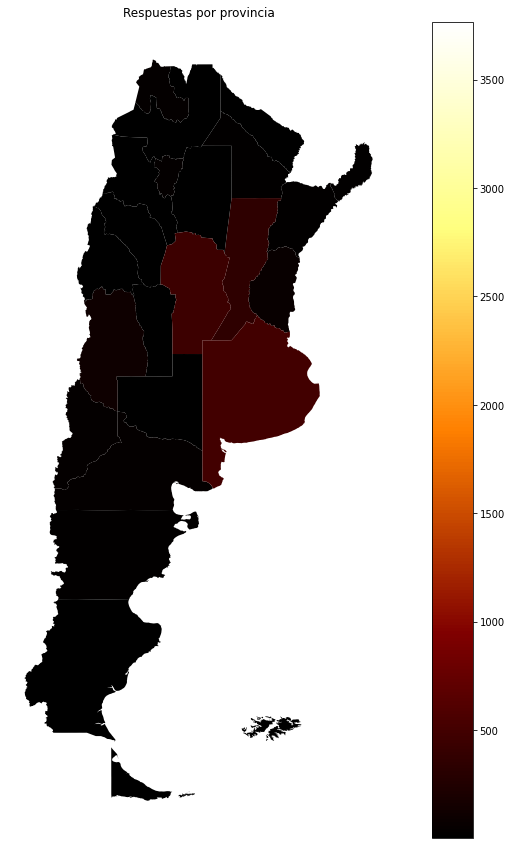

In [21]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='count', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
ax.set_title('Respuestas por provincia')
plt.show()

Como la escala está dominada por CABA, apenas podemos ver que PBA, Santa Fe y Córdoba tienen datos y el resto del país casi nada. Usemos logaritmo en base 10 para ver la orden de magnitud de cada provincia.

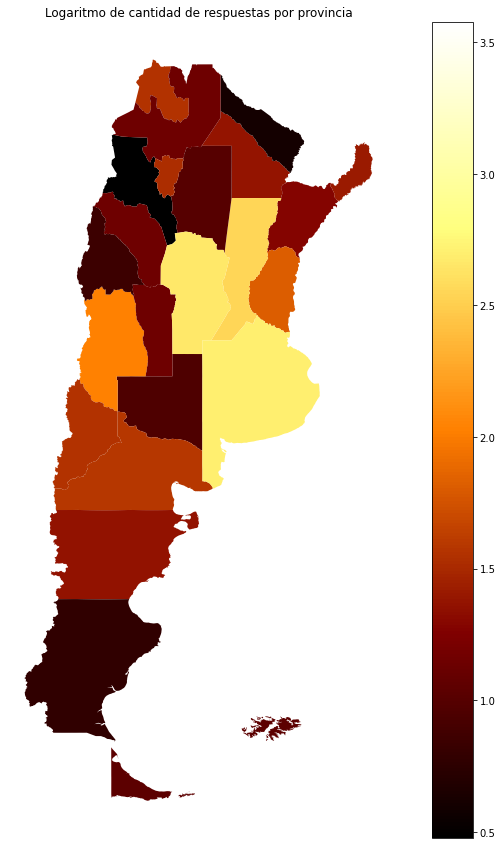

In [22]:
provinces['log(count)'] = provinces['count'].apply(lambda x: math.log10(x))
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='log(count)', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
ax.set_title('Logaritmo de cantidad de respuestas por provincia')
plt.show()

In [23]:
provinces[['provincia', 'count']]

,provincia,count
0,Ciudad Autónoma de Buenos Aires,3764
1,Catamarca,3
2,Chaco,24
3,Chubut,23
4,Corrientes,19
5,Entre Ríos,66
6,Formosa,4
7,Jujuy,36
8,La Pampa,9
9,La Rioja,14


Vemos algún patrón en estos gráficos. El área de la Pampa Húmeda (Provincia de Buenos Aires, Santa Fe, Córdoba, La Pampa) parece tener más datos, y valores más altos. El Noroeste (Jujuy, Salta, Tucumán, La Rioja, Catamarca) tienen menos observaciones y promedios más bajos. En la Patagonia (Neuquén, Río Negro, Chubut, Santa Cruz) Santa Cruz parece tener un sueldo más bajo que el resto, pero vemos que son pocas observaciones. Pasa lo opuesto en el norte, donde Formosa es más alto pero sólo con 3 personas. Cuyo (Mendoza, San Luis, San Juan) parece ser menos homogéneo, sabiendo que San Luis tiene políticas de incentivo a la actividad económica tiene sentido.

In [8]:
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
provinces_geo['region'] = provinces_geo['provincia'].apply(lambda x: regions_map[x])
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])

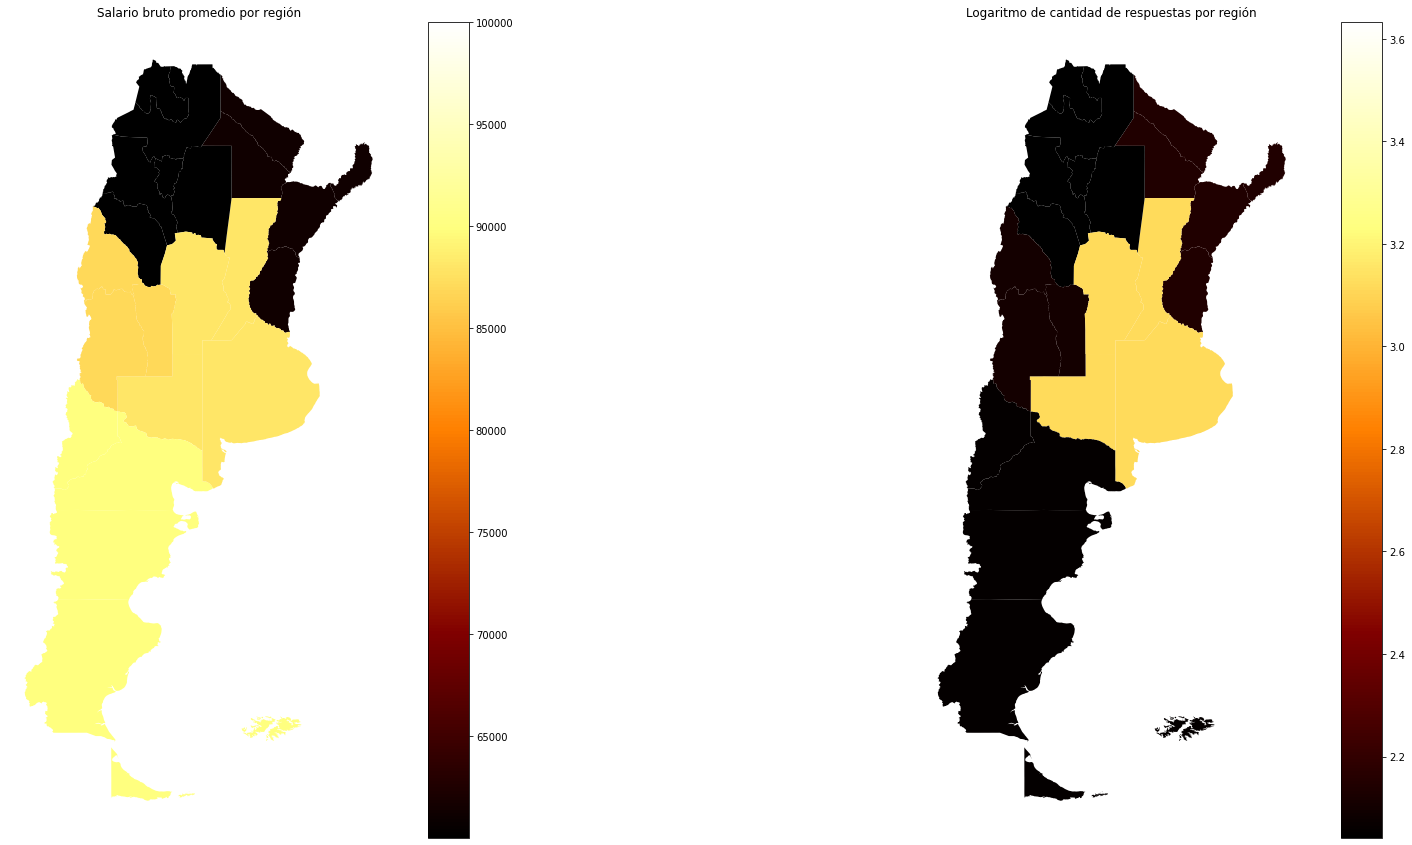

In [9]:
df_regions = df[['region', 'Salario mensual BRUTO (en tu moneda local)']].groupby('region').agg(['median', 'count']).sort_values(('Salario mensual BRUTO (en tu moneda local)', 'median'))

regions = provinces_geo.join(df_regions['Salario mensual BRUTO (en tu moneda local)'], on=['region'])
regions['log(count)'] = regions['count'].apply(lambda x: math.log10(x))


f, (ax0, ax1) = plt.subplots(ncols=2, figsize=(30, 15))
ax0 = regions.plot(column='median', cmap='afmhot', ax=ax0, legend=True)
ax0.axis('off')
ax0.set_title('Salario bruto promedio por región')

ax1 = regions.plot(column='log(count)', cmap='afmhot', ax=ax1, legend=True)
ax1.axis('off')
ax1.set_title('Logaritmo de cantidad de respuestas por región')

plt.show()

In [26]:
regions[['region', 'median', 'count']].groupby('region').mean()

,median,count
region,,
AMBA,100000.0,4288
Cuyo,87000.0,128
NEA,61280.0,139
NOA,60013.5,110
Pampa,88000.0,1316
Patagonia,90000.0,114


Ahora tenemos una mediana para cada región, y tenemos muestra de dos dígitos o más en cada una.

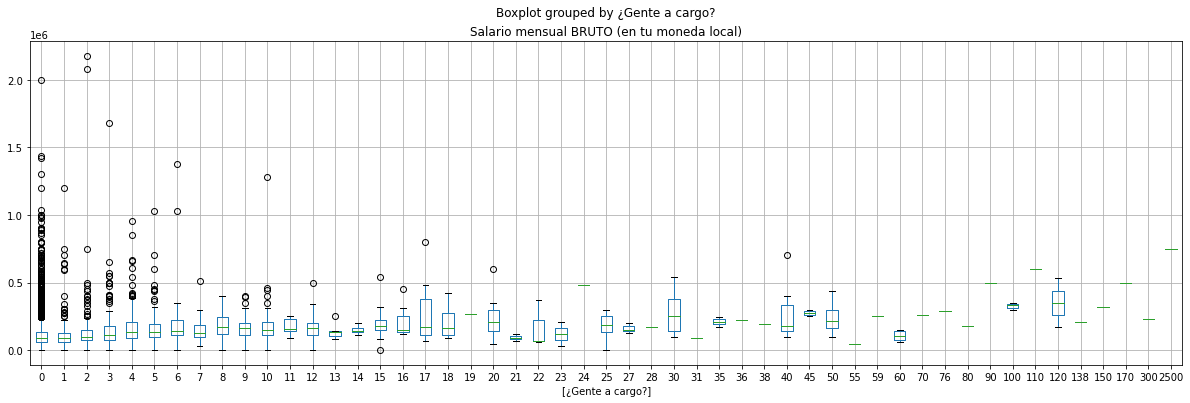

In [27]:
df[['¿Gente a cargo?', 'Salario mensual BRUTO (en tu moneda local)']].boxplot(by='¿Gente a cargo?', figsize=(20, 6));

In [28]:
df['Salario mensual BRUTO (en tu moneda local)'].max()

2180000.0

In [10]:
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]

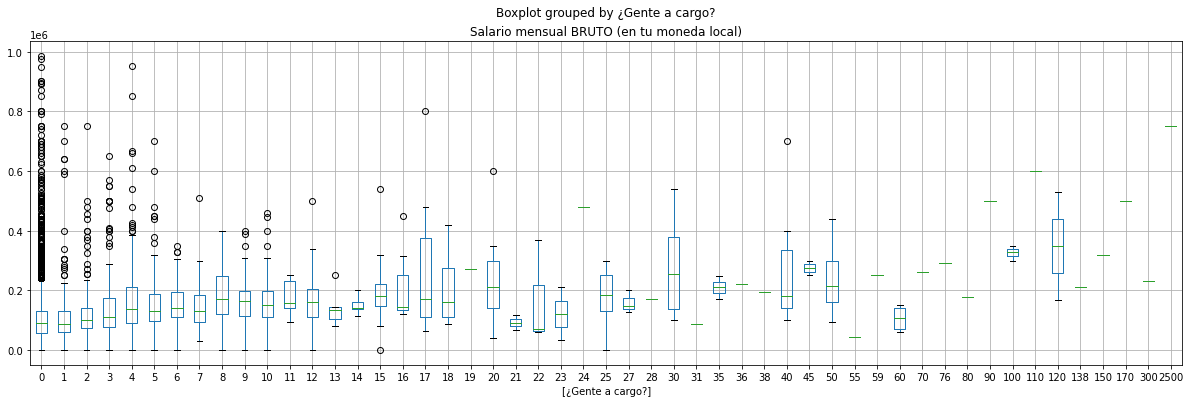

In [30]:
df[['¿Gente a cargo?', 'Salario mensual BRUTO (en tu moneda local)']].astype(int).sort_values(by='¿Gente a cargo?').boxplot(by='¿Gente a cargo?', figsize=(20, 6));

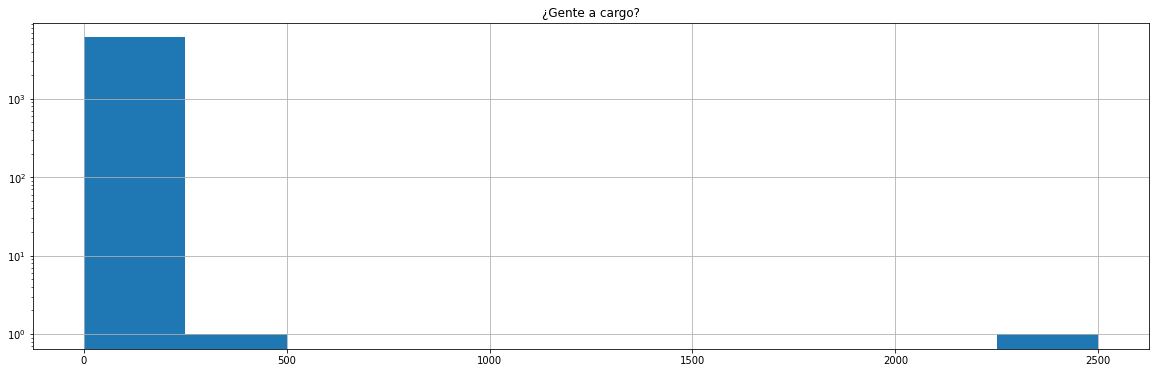

In [31]:
df[['¿Gente a cargo?']].astype(int).sort_values(by='¿Gente a cargo?').hist(figsize=(20, 6), log=True);

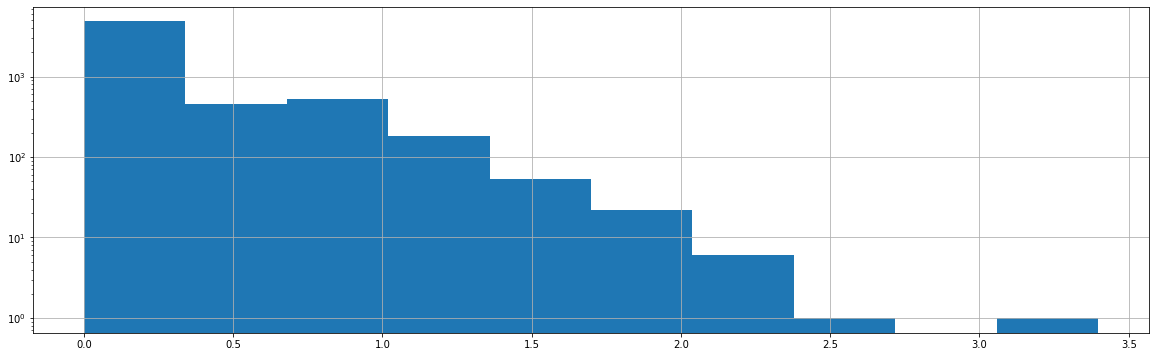

In [32]:
df['¿Gente a cargo?'].astype(int).sort_values().apply(lambda x: math.log10(x+1)).hist(figsize=(20, 6), log=True);

In [33]:
g = df['¿Gente a cargo?'].astype(int)
pd.qcut(g, 10, duplicates='drop', retbins=True)[1]

array([0.0e+00, 2.0e+00, 5.0e+00, 2.5e+03])

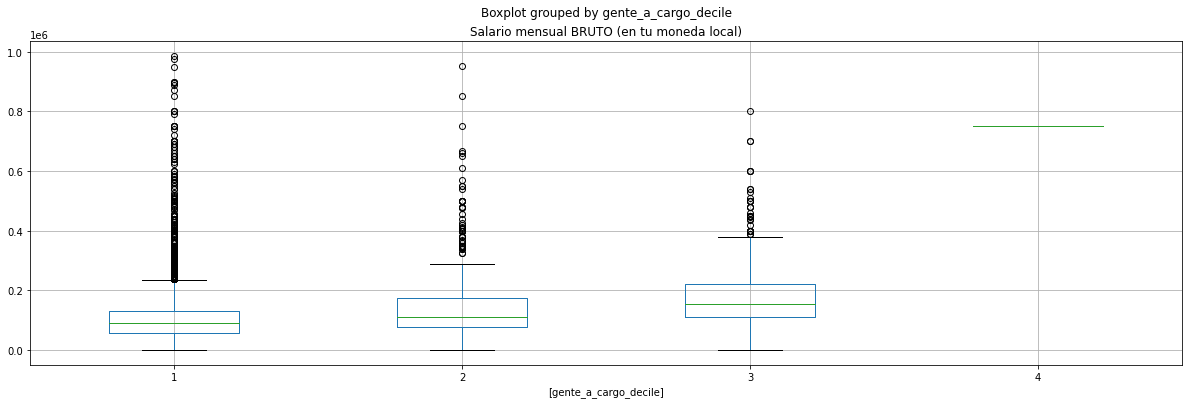

In [34]:
deciles = pd.qcut(g, 10, duplicates='drop', retbins=True)[1]
df['gente_a_cargo_decile'] = df['¿Gente a cargo?'].astype(int).apply(lambda x: (deciles <= x).sum())
df[['gente_a_cargo_decile', 'Salario mensual BRUTO (en tu moneda local)']].astype(int).sort_values(by='gente_a_cargo_decile').boxplot(by='gente_a_cargo_decile', figsize=(20, 6));

Ahora ya estamos listos para armar una predicción básica. Calculamos el promedio para la gente de la misma región geográfica, mismo género (considerando "otro" como "mujer" por ser más parecido su sueldo) y mismo decil con gente a cargo.

In [35]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}

In [36]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class BaseModel:
    def __init__(self, num_gente_a_cargo_groups=10):
        self.num_gente_a_cargo_groups = num_gente_a_cargo_groups

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: regions_map[x])
        df['gender'] = X['Me identifico'].apply(lambda x: gender_map[x])
        df['gente_a_cargo_group'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: (self.groups_ <= x).sum())
        df['key'] = df.apply(lambda row: '{},{},{}'.format(row['region'], row['gender'], row['gente_a_cargo_group']), axis=1)
        return df

    def get_params(self, deep=True):
        return {'num_gente_a_cargo_groups': self.num_gente_a_cargo_groups}

    def set_params(self, **params):
        if 'num_gente_a_cargo_groups' in params:
            self.num_gente_a_cargo_groups = params['num_gente_a_cargo_groups']
    
    def fit(self, X, y):
        self.groups_ = pd.qcut(X['¿Gente a cargo?'].astype(int), self.num_gente_a_cargo_groups, duplicates='drop', retbins=True)[1]
        
        df = self._get_df(X)
        df['value'] = y
        self.mean_ = y.mean()
        self.means_ = df[['key', 'value']].groupby('key').mean().to_dict()['value']
        return self
    
    def predict(self, X):
        df = self._get_df(X)
        return df['key'].apply(lambda key: self.means_.get(key, self.mean_)).rename('y_pred')
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
m = BaseModel()
m.fit(X, y).score(X, y)

0.07541726381421965

In [37]:
cross_val_score(BaseModel(), X, y)

array([0.0735715 , 0.06503895, 0.02053466, 0.05719935, 0.05524577])

In [38]:
best_p = 10
best_s = cross_val_score(BaseModel(best_p), X, y).mean()
for i in range(1, 100):
    s = cross_val_score(BaseModel(i), X, y).mean()
    if s > best_s:
        best_s = s
        best_p = i
(best_s, best_p)

(0.0613869752860974, 60)

Este modelo es bastante peor de lo que esperaba. Veamos un modelo de regresión lineal con estos mismos datos.

In [39]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(regions_map[x], self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].apply(lambda x: regions_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.06666881447094294

In [40]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.06565182995243539

In [41]:
gender_map = {
    'Hombre': 2,
    'Mujer': 1,
    'Otros': 0,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.0660057654777814

Probando no agrupar otros con mujeres el modelo empeora, dejando las provincias sin agrupar el modelo mejora. Usar logaritmo en vez de deciles para gente a cargo mejora (¡y es más sencillo de implementar!). Quedemosnos el mejor modelo que tenemos hasta ahora y agreguemos experiencia y nivel de estudio.

In [42]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.13316477133214902

In [43]:
df['Estado'].value_counts()

Completado    2902
En curso      1682
Incompleto    1495
Name: Estado, dtype: int64

In [44]:
df['Nivel de estudios alcanzado'].value_counts()

Universitario    4122
Terciario        1133
Secundario        448
Posgrado          341
Doctorado          30
Posdoctorado        3
Primario            2
Name: Nivel de estudios alcanzado, dtype: int64

In [45]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = X[['Nivel de estudios alcanzado', 'Estado']].apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.study_ = pd.concat((X[['Nivel de estudios alcanzado', 'Estado']].apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']

        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.1471270965458686

In [46]:
df['Carrera'].value_counts()

Ingeniería en Sistemas de Información        1186
Ingeniería en Informática                     781
Analista de Sistemas                          595
Licenciatura en Ciencias dela Computación     298
Licenciatura en Sistemas de Información       298
                                             ... 
Programacion y Desarrollo de videojuegos        1
Ciencias Antropológicas                         1
Tec en Software Libre                           1
Bioquímica                                      1
Desarrollo Web Full Stack                       1
Name: Carrera, Length: 495, dtype: int64

In [47]:
df['Universidad'].value_counts()

UTN - Universidad Tecnológica Nacional        1373
UBA - Universidad de Buenos Aires              783
UNLaM - Universidad Nacional de La Matanza     236
UADE - Universidad Argentina De la Empresa     204
UAI - Universidad Abierta Interamericana       192
                                              ... 
Cursos                                           1
Centro de formación profesional                  1
COMENIO                                          1
Universidad José María Vargas                    1
Orsino                                           1
Name: Universidad, Length: 799, dtype: int64

In [48]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
                X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.06327852034841056

In [49]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.14788958978320405

In [50]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15089982220857717

In [51]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] * 5 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
                X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.14436766675446938

In [52]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15089982220857717

## doc2vec

Ya tenemos un modelo base que explica un 16% del sueldo. No es un gran número pero es una base sobre la que trabajar. Muchas de las variables que tenemos son categóricas así que probemos hacer un documento con cada registro y aplicar doc2vec para generar embeddings.
Empecemos sólo con los lenguajes de programación para ver cómo funciona.

In [53]:
documents = [TaggedDocument([x for x in df.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x], [i]) for i in range(df.shape[0])]
model = Doc2Vec(documents, vector_size=2, epochs=30)

In [54]:
embeddings = [model.docvecs[i] for i in range(len(model.docvecs))]

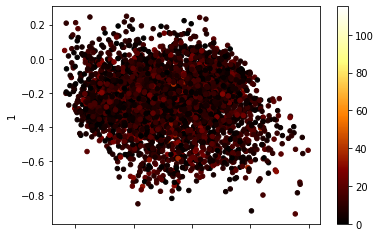

In [55]:
pd.DataFrame(embeddings).plot.scatter(0, 1, c=df['Años de experiencia'], cmap='afmhot');

In [56]:
class EmbeddingModel:
    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument([x for x in X.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x], [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=4, alpha=0.025, min_count=2, epochs=300)
        self.model_ = LinearRegression()
        self.model_.fit(pd.DataFrame([self.doc2vec_.docvecs[i] for i in range(len(self.doc2vec_.docvecs))]), y)
        return self
    
    def predict(self, X):
        return self.model_.predict([self.doc2vec_.infer_vector([x for x in X.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x]) for i in range(X.shape[0])])
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Lenguajes de programación']], np.log(df['Salario mensual BRUTO (en tu moneda local)'])
cross_val_score(EmbeddingModel(), X, y).mean()

0.0031796370214281166

In [57]:
class LinearEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument(self._row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=self.vector_size, alpha=0.025, min_count=2, epochs=self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, np.log(df['Salario mensual BRUTO (en tu moneda local)'])
cross_val_score(LinearEmbeddingModel(), X, y).mean()

0.05570899178200066

In [58]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=10), X, y).mean()

0.055785801006265914

In [59]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=100), X, y).mean()

0.05577736892629259

In [60]:
cross_val_score(LinearEmbeddingModel(vector_size=100, epochs=10), X, y).mean()

0.05577307895025459

In [61]:
cross_val_score(LinearEmbeddingModel(vector_size=20, epochs=20), X, y).mean()

0.05576247409315895

In [62]:
cross_val_score(LinearEmbeddingModel(vector_size=20, epochs=300), X, y).mean()

0.055787071540253017

In [63]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=300), X, y).mean()

0.05577496101413859

In [64]:
class XGBoostModel:
    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, np.log(df['Salario mensual BRUTO (en tu moneda local)'])
cross_val_score(XGBoostModel(), X, y).mean()

0.0542433874760118

In [65]:
class XGBoostEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument(self._row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=self.vector_size, alpha=0.025, min_count=2, epochs=self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, np.log(df['Salario mensual BRUTO (en tu moneda local)'])
cross_val_score(XGBoostEmbeddingModel(vector_size=20, epochs=400), X, y).mean()

-0.019273957309335697

Yaks. Los embeddings parecen ser malos predictores por sí solo, no mejorar considerablemente un modelo de regresión lineal, y empeorar el un XGBoost.

In [66]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Años de experiencia']], np.log(df['Salario mensual BRUTO (en tu moneda local)'])
m = LinearModel()
m.fit(X, y).score(X, y)
cross_val_score(LinearModel(), X, y).mean()

0.05478082474251193

In [11]:
df = df[df['Años en la empresa actual'] < 40]

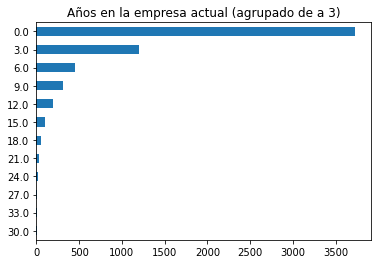

In [68]:
df['Años en la empresa actual'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años en la empresa actual (agrupado de a 3)');

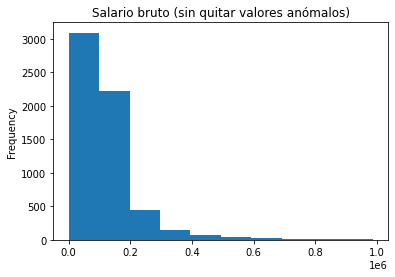

In [69]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto (sin quitar valores anómalos)');

In [70]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().head()

3386    1.0
2310    1.0
2239    1.0
5917    1.0
1346    1.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [71]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail()

3497    900000.0
5920    950000.0
1901    952500.0
4735    975000.0
6120    986840.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

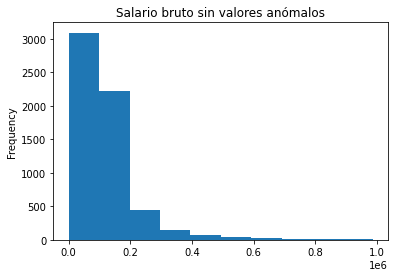

In [72]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto sin valores anómalos');

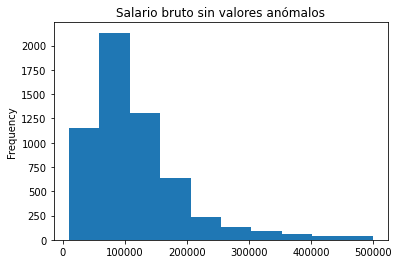

In [73]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 500000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto sin valores anómalos');

In [12]:
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]

In [75]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['province'] = X['Dónde estás trabajando'].apply(lambda x: self.province_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.province_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']

        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', 'Años de experiencia']], np.log(df['Salario mensual BRUTO (en tu moneda local)'])
m = LinearModel()
m.fit(X, y).score(X, y)
cross_val_score(LinearModel(), X, y).mean()

0.22516319574186233

In [76]:
doc2vec_cache = {}

def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace("", "")}' for k in (
            '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ]

def get_doc2vec(df, vector_size, epochs):
    global doc2vec_cache
    h = pd.util.hash_pandas_object(df).sum(), vector_size, epochs
    if h not in doc2vec_cache:
        documents = [TaggedDocument(row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        doc2vec_cache[h] = Doc2Vec(documents, vector_size=vector_size, alpha=0.025, min_count=2, epochs=epochs)
    return doc2vec_cache[h]
    
    
class LinearEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

In [77]:
X, y = df, np.log(df['Salario mensual BRUTO (en tu moneda local)'])
cross_val_score(LinearEmbeddingModel(), X, y).mean()

0.2796000157616515

In [78]:
for vector_size in range(3, 15, 4):
    for epochs in range(3, 15, 4):
        X, y = df, np.log(df['Salario mensual BRUTO (en tu moneda local)'])
        print(
            vector_size,
            epochs,
            cross_val_score(LinearEmbeddingModel(vector_size=vector_size, epochs=epochs), X, y).mean(),
        )

3 3 0.2796371652869699
3 7 0.27961404351367536
3 11 0.2795978522767212
7 3 0.27962724459084976
7 7 0.27961926552096916
7 11 0.2796258498525664
11 3 0.2796658796321997
11 7 0.2796472439733583
11 11 0.27961143352586293


In [79]:
space = {
    'vector_size': hp.choice('vector_sice', range(3, 100)),
    'epochs': hp.choice('epochs', range(10, 400)),
}

def objective(params):
    score = cross_val_score(LinearEmbeddingModel(**params), X, y).mean()
    print(params, score)
    return -score

fmin(objective, space, algo=tpe.suggest, max_evals=100)

{'epochs': 319, 'vector_size': 82}                     
0.279606377173257                                      
{'epochs': 72, 'vector_size': 77}                                                  
0.27962874869413595                                                                
{'epochs': 247, 'vector_size': 6}                                                    
0.2796506139556003                                                                   
{'epochs': 377, 'vector_size': 36}                                                   
0.2795978843434974                                                                  
{'epochs': 243, 'vector_size': 46}                                                  
0.2795999551665434                                                                  
{'epochs': 55, 'vector_size': 8}                                                    
0.27964794315924574                                                                 
{'epochs': 153, 'vector_size': 9}    

0.2796398751100462                                                                    
{'epochs': 25, 'vector_size': 5}                                                      
0.27962234870923475                                                                   
{'epochs': 318, 'vector_size': 75}                                                    
0.27959658043492475                                                                   
{'epochs': 205, 'vector_size': 61}                                                    
0.2796438363924256                                                                    
{'epochs': 100, 'vector_size': 89}                                                    
0.27964039596698625                                                                   
100%|██████████| 100/100 [1:29:00<00:00, 53.40s/trial, best loss: -0.27967287728368095]


{'epochs': 219, 'vector_sice': 60}

In [80]:
class XGBoostEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
fmin(objective, space, algo=tpe.suggest, max_evals=100)

{'epochs': 242, 'vector_size': 28}                     
0.27965690922746617                                    
{'epochs': 68, 'vector_size': 70}                                                    
0.2796014547198838                                                                   
{'epochs': 15, 'vector_size': 84}                                                    
0.27966824848724553                                                                  
{'epochs': 85, 'vector_size': 85}                                                    
0.27963847960499955                                                                  
{'epochs': 68, 'vector_size': 73}                                                    
0.27962006798122296                                                                  
{'epochs': 173, 'vector_size': 84}                                                   
0.2795487654073325                                                                   
{'epochs': 318, 'vector_size

{'epochs': 50, 'vector_size': 98}                                                    
0.279597731294854                                                                    
{'epochs': 35, 'vector_size': 77}                                                    
0.27959391149455065                                                                  
{'epochs': 23, 'vector_size': 53}                                                    
0.27965025877622074                                                                  
{'epochs': 205, 'vector_size': 47}                                                   
0.27959904460224                                                                     
100%|██████████| 100/100 [1:29:17<00:00, 53.57s/trial, best loss: -0.2796762787648027]


{'epochs': 123, 'vector_sice': 74}

In [81]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15547296851147344

Estos resultados son decepcionantes. Agregas los embeddings disminuye la calidad del modelo. Antes de desechar doc2vec en frustración, quiero probar aumentar su responsabilidad dandole la información que preprocesamos.

In [82]:
doc2vec_cache = {}

def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Dónde estás trabajando',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'{k}={math.ceil(math.log10(int(row[k]) + 1))}' for k in (
            '¿Gente a cargo?',
            'Años de experiencia',
        )
    ]

def get_doc2vec(df, vector_size, epochs):
    global doc2vec_cache
    h = pd.util.hash_pandas_object(df).sum(), vector_size, epochs
    if h not in doc2vec_cache:
        documents = [TaggedDocument(row_to_words(df.iloc[i]), [i]) for i in range(df.shape[0])]
        doc2vec_cache[h] = Doc2Vec(documents, vector_size=vector_size, alpha=0.025, min_count=2, epochs=epochs)
    return doc2vec_cache[h]
    
    
class LinearEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        return X.apply(lambda row: self._row_to_embeddings(row), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
    
cross_val_score(LinearEmbeddingModel(100, 100), df, y).mean()

-0.007884011564410631

In [83]:
class XGBoostEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        return X.apply(lambda row: self._row_to_embeddings(row), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
    
cross_val_score(XGBoostEmbeddingModel(100, 100), df, y).mean()

-0.1221326215582487

### Conclusión

Todo parece indicar que la salida de doc2vec no sirve como entrada a los modelos de regresión de XGBoost y lineales. Probablemente sea un error en mi uso.

## Autoencoder

Una alternativa que quiero considerar para hacer embeddings es autoencoders. Deberían ser como doc2vec, ya que genera embeddings del mismo input, pero tengo esperanza de que funcione mejor.

In [84]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Dónde estás trabajando',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'{k}={math.ceil(math.log10(int(row[k]) + 1))}' for k in (
            '¿Gente a cargo?',
            'Años de experiencia',
        )
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1
len(counts)

3638

In [85]:
pd.Series(counts).sort_values(ascending=False).head(20)

¿Contribuís a proyectos open source?=No                             5035
Tipo de contrato=Full-Time                                          5009
Me identifico=Hombre                                                4969
Lenguajes de programación=javascript                                4866
Orientación sexual=Heterosexual                                     4737
¿Y en tu celular?=Android                                           4707
¿Tenés guardias?=No                                                 4476
¿Gente a cargo?=0                                                   4434
Lenguajes de programación=sql                                       4170
¿A qué eventos de tecnología asististe en los últimos 12 meses?=    4089
Nivel de estudios alcanzado=Universitario                           3999
Dónde estás trabajando=Ciudad Autónoma de Buenos Aires              3644
Lenguajes de programación=html                                      3594
¿Qué SO usás en tu laptop/PC para trabajar?=Windows

In [86]:
pd.Series(counts).sort_values(ascending=False).tail(20)

¿A qué eventos de tecnología asististe en los últimos 12 meses?=veem                              1
Trabajo de=Developer QA - Ambos roles                                                             1
¿A qué eventos de tecnología asististe en los últimos 12 meses?=hacktivitycon                     1
¿A qué eventos de tecnología asististe en los últimos 12 meses?=devseccon                         1
¿A qué eventos de tecnología asististe en los últimos 12 meses?=cloud 365 microsofot              1
QA / Testing=jenkins                                                                              1
¿A qué eventos de tecnología asististe en los últimos 12 meses?=icassp 2020                       1
¿A qué eventos de tecnología asististe en los últimos 12 meses?=varios de ciberseguridad          1
Carrera=abogado auditor militar                                                                   1
¿A qué eventos de tecnología asististe en los últimos 12 meses?=cor0nac0n                         1


Raro las plataformas separadas por coma sin espacio, ni mayúsculas. Veamos si es normal eso agarrando un registro cualquiera.

In [87]:
df.iloc[20]['Plataformas']

'AIX, HP-UX, Linux, OpenStack, Solaris, VMWare'

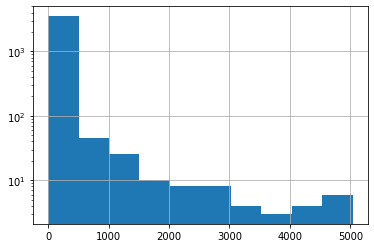

In [88]:
pd.Series(counts).hist(log=True);

In [89]:
pd.Series(counts).shape[0]

3638

In [90]:
(pd.Series(counts) > 1).sum()

1025

In [91]:
valid_words = [word for word, c in counts.items() if c > 1]
len(valid_words)

1025

In [92]:
def row_to_bools(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words])
bools = df.apply(row_to_bools, axis=1)
bools

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,True,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,True,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6410,False,True,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
6411,False,True,True,True,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6412,False,True,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
6413,False,False,False,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [93]:
cross_val_score(LinearRegression(), bools, df['Salario mensual BRUTO (en tu moneda local)']).mean()

-1.7016011903351032e+22

In [94]:
cross_val_score(LinearRegression(), bools, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

-3.7763406533704244e+21

In [95]:
cross_val_score(xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}), bools, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.5864890571078607

In [96]:
encoding_dim = 10
input_img = Input(shape=(bools.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/500
19/19 [==============================] - 0s 18ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 2/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11

19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 84/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 85/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 86/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 87/500
19/19 [==============================] - 0s 7ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 88/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 89/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 90/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 91/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 92/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 93/500


19/19 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 246/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 247/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 248/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 249/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 250/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 251/500
19/19 [==============================] - 0s 7ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 252/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 253/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 254/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6919
Epoc

19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 408/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 409/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 410/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 411/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 412/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 413/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 414/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 415/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 416/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6910 - val_loss: 0.6911
Epoc

In [97]:
pd.DataFrame(encoded_imgs)

,0,1,2,3,4,5,6,7,8,9
0,0.045715,0.178131,0.000000,0.073605,0.000000,0.000000,0.238535,0.186586,0.000000,0.000000
1,0.426422,0.424195,0.396042,0.044913,0.035194,0.283805,0.000000,0.000000,0.416968,0.000000
2,0.411984,0.000000,0.304545,0.000000,0.000000,0.136869,0.091132,0.013419,0.390472,0.000000
3,0.460506,0.000000,0.000000,0.041361,0.000000,0.030095,0.000000,0.291000,0.079644,0.038866
4,0.377886,0.550055,0.000000,0.025127,0.000000,0.000000,0.000000,0.000000,0.000000,0.196031
...,...,...,...,...,...,...,...,...,...,...
1172,0.331767,0.059930,0.000000,0.043270,0.021733,0.000000,0.015128,0.363810,0.000000,0.000000
1173,0.219506,0.307779,0.272493,0.139280,0.000000,0.225769,0.000000,0.084836,0.439813,0.024214
1174,0.295685,0.255869,0.058375,0.008600,0.110514,0.000000,0.096573,0.000000,0.873593,0.203310
1175,0.316782,0.000000,0.000000,0.279129,0.077321,0.024309,0.000000,0.000000,0.289016,0.000000


In [98]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
5850,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4618,False,True,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
207,False,True,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4528,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5604,True,True,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,False,True,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6046,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4211,False,True,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
303,False,True,True,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [99]:
LinearRegression().fit(encoder.predict(X_train), y_train).score(encoded_imgs, y_test)

0.11736567303969236

In [100]:
LinearRegression().fit(encoder.predict(X_train), np.log(y_train)).score(encoded_imgs, np.log(y_test))

0.11971713753715918

In [101]:
xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
).fit(encoder.predict(X_train), np.log(y_train)).score(encoded_imgs, np.log(y_test))

0.057412997569866175

In [102]:
encoding_dim = 100
input_img = Input(shape=(bools.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/500
19/19 [==============================] - 0s 14ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 2/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 3/500
19/19 [==============================] - 0s 12ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 4/500
19/19 [==============================] - 0s 11ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 5/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 6/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 7/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 8/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 9/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 10/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6935

19/19 [==============================] - 0s 10ms/step - loss: 0.6914 - val_loss: 0.6914
Epoch 163/500
19/19 [==============================] - 0s 11ms/step - loss: 0.6914 - val_loss: 0.6914
Epoch 164/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6914 - val_loss: 0.6914
Epoch 165/500
19/19 [==============================] - 0s 11ms/step - loss: 0.6914 - val_loss: 0.6914
Epoch 166/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6914 - val_loss: 0.6914
Epoch 167/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6914 - val_loss: 0.6914
Epoch 168/500
19/19 [==============================] - 0s 12ms/step - loss: 0.6914 - val_loss: 0.6913
Epoch 169/500
19/19 [==============================] - 0s 12ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 170/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 171/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6913 - val_loss: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.6892 - val_loss: 0.6892
Epoch 323/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6892 - val_loss: 0.6892
Epoch 324/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6892 - val_loss: 0.6892
Epoch 325/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6892 - val_loss: 0.6892
Epoch 326/500
19/19 [==============================] - 0s 11ms/step - loss: 0.6892 - val_loss: 0.6892
Epoch 327/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6892 - val_loss: 0.6892
Epoch 328/500
19/19 [==============================] - 0s 11ms/step - loss: 0.6892 - val_loss: 0.6891
Epoch 329/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6891 - val_loss: 0.6891
Epoch 330/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6891 - val_loss: 0.6891
Epoch 331/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6891 - val_loss: 0

19/19 [==============================] - 0s 10ms/step - loss: 0.6869 - val_loss: 0.6869
Epoch 483/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6868 - val_loss: 0.6868
Epoch 484/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6868 - val_loss: 0.6868
Epoch 485/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6868 - val_loss: 0.6868
Epoch 486/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6868 - val_loss: 0.6868
Epoch 487/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6868 - val_loss: 0.6868
Epoch 488/500
19/19 [==============================] - 0s 11ms/step - loss: 0.6868 - val_loss: 0.6868
Epoch 489/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6867 - val_loss: 0.6867
Epoch 490/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6867 - val_loss: 0.6867
Epoch 491/500
19/19 [==============================] - 0s 10ms/step - loss: 0.6867 - val_loss: 0

In [103]:
xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
).fit(encoder.predict(X_train), np.log(y_train)).score(encoded_imgs, np.log(y_test))

0.38267475422988995

In [104]:
encoding_dim = 100
input_img = Input(shape=(bools.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
).fit(encoder.predict(X_train), np.log(y_train)).score(encoder.predict(X_test), np.log(y_test))

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 0.6948 - val_loss: 0.6948
Epoch 2/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6948 - val_loss: 0.6948
Epoch 3/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6948 - val_loss: 0.6948
Epoch 4/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6948 - val_loss: 0.6948
Epoch 5/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6948 - val_loss: 0.6948
Epoch 6/20
19/19 [==============================] - 0s 11ms/step - loss: 0.6948 - val_loss: 0.6948
Epoch 7/20
19/19 [==============================] - 0s 11ms/step - loss: 0.6947 - val_loss: 0.6948
Epoch 8/20
19/19 [==============================] - 0s 11ms/step - loss: 0.6947 - val_loss: 0.6947
Epoch 9/20
19/19 [==============================] - 0s 11ms/step - loss: 0.6947 - val_loss: 0.6947
Epoch 10/20
19/19 [==============================] - 0s 10ms/step - loss: 0.6947 - val_loss: 0.6947
Epoch 11/

0.3863188537362756

In [105]:
res = {};
for encoding_dim in range(1, 300):
    input_img = Input(shape=(bools.shape[1],))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


    X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
    autoencoder.fit(X_train, X_train,
                    epochs=4,
                    batch_size=256,
                    shuffle=True,
                    verbose=False)
    res[encoding_dim] = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
    ).fit(encoder.predict(X_train), np.log(y_train)).score(encoder.predict(X_test), np.log(y_test))
    if encoding_dim % 3 == 0:
        best = max(res.values())
        k = [k for k, v in res.items() if v == best]
        print(f'after {encoding_dim} best {k} ({best})')

after 3 best [2] (-0.0045920666954668565)
after 6 best [6] (0.02750553049696003)
after 9 best [6] (0.02750553049696003)
after 12 best [12] (0.06520512046187432)
after 15 best [13] (0.10119509857048214)
after 18 best [18] (0.15283179291816373)
after 21 best [18] (0.15283179291816373)
after 24 best [23] (0.21570524665673063)
after 27 best [27] (0.24445594434475004)
after 30 best [27] (0.24445594434475004)
after 33 best [33] (0.24781350750657793)
after 36 best [33] (0.24781350750657793)
after 39 best [38] (0.277240282667632)
after 42 best [38] (0.277240282667632)
after 45 best [44] (0.3016465599175494)
after 48 best [44] (0.3016465599175494)
after 51 best [51] (0.304178913005127)
after 54 best [51] (0.304178913005127)
after 57 best [51] (0.304178913005127)
after 60 best [60] (0.3662293983568562)
after 63 best [60] (0.3662293983568562)
after 66 best [60] (0.3662293983568562)
after 69 best [60] (0.3662293983568562)
after 72 best [60] (0.3662293983568562)
after 75 best [75] (0.37962272451995

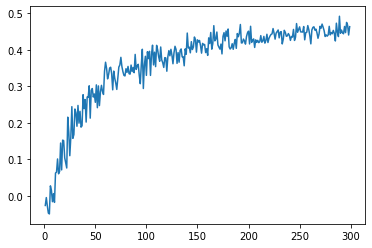

In [106]:
pd.Series(res).plot();

In [15]:
class Model:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Estado',
                'Carrera',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v.lower().strip().replace(".", "")}' for k in (
                '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ] + [
            f'provincia={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 1]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

In [109]:
trials = Trials()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)

In [ ]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(10, 30, dtype=int)),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 20, 1),
    'subsample': hp.uniform ('subsample', 0.8, 1),
    'n_estimators' : hp.choice('n_estimators', np.arange(10, 400, 5, dtype=int)),
    'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
    'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
}

def objective(space):
    acc = cross_val_score(estimator=Model(**space), X=X_train, y=y_train, cv=5).mean()
    print(space, acc)
    return {'loss': -acc, 'status': STATUS_OK}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=159,
            trials=trials)

{'colsample_bytree': 0.9500000000000001, 'gamma': 0.65, 'learning_rate': 0.05, 'max_depth': 16, 'min_child_weight': 7.0, 'n_estimators': 110, 'subsample': 0.9156548188288558}
0.5166396793019336                                     
{'colsample_bytree': 0.8500000000000001, 'gamma': 0.55, 'learning_rate': 0.125, 'max_depth': 16, 'min_child_weight': 11.0, 'n_estimators': 220, 'subsample': 0.9136350619739163}
0.504027090733904                                                                    
  1%|▏         | 2/159 [05:42<6:56:12, 159.06s/trial, best loss: -0.5166396793019336]

In [13]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}

In [18]:
cross_val_score(estimator=Model(**best), X=X_train, y=y_train, cv=5).mean()

0.5363001268090939

In [19]:
class Model:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en los últimos 12 meses?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en los últimos 12 meses?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))


cross_val_score(estimator=Model(**best), X=df, y=df['Salario mensual BRUTO (en tu moneda local)'], cv=5).mean()

0.554803947805089

In [20]:
from nyoka import xgboost_to_pmml
from sklearn.pipeline import Pipeline

model = Model(**best).fit(df, df['Salario mensual BRUTO (en tu moneda local)'])
model.regressor_.base_score = 0.0
xgboost_to_pmml(pipeline=Pipeline([("model", model.regressor_)]),
                col_names=model.valid_words_ + ['¿Gente a cargo?', 'Años de experiencia','Tengo'],
                target_name="salary",
                pmml_f_name="decision_tree.pmml")